# Notatki

 * Jakbyśmy mieli do czynienia z ciagłym przypływem próbek bez żadnych przerw to moglibyśmy pozwolić sobie na dropnięcie czasu
 * Lepiej celować w wielkość typu 200-400 time steps w LSTM(patrz: [źródło](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/))

# Sprawdzanie środowiska

In [1]:
from platform import python_version

print(python_version())

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

3.7.4


# Załadowanie danych

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical

# fix random bo tak ( ͡° ͜ʖ ͡°)
odp = 42
numpy.random.seed(odp)

Using TensorFlow backend.


In [3]:
%ls -l data

 Volume in drive D is Data
 Volume Serial Number is 82E7-60C3

 Directory of D:\Studia\Auto_Tag


 Directory of D:\Studia\Auto_Tag\data

26.05.2020  07:13    <DIR>          .
26.05.2020  07:13    <DIR>          ..
04.05.2020  12:59           286˙105 data_real_5s.csv
26.05.2020  07:13        16˙127˙004 data_real_5s_without_step_25_05.csv
09.04.2020  16:52         1˙076˙355 easy.csv
09.04.2020  16:52         2˙924˙235 hard.csv
09.04.2020  16:52         2˙787˙990 medium.csv
04.05.2020  14:29         3˙955˙274 rawData.csv
               6 File(s)     27˙156˙963 bytes
               2 Dir(s)  255˙654˙334˙464 bytes free


File Not Found


In [4]:
data_type = '5s_new' # '5s' or '5s_new' or 'raw'

if data_type == 'raw':
    df = pd.read_csv("data//rawData.csv")
    tmp = df.pop('target')
    df['activity'] = tmp
else:
    df = pd.read_csv("data//data_real_5s_without_step_25_05.csv", index_col = 0)
    tmp = df.pop('activity')
    df['activity'] = tmp
    
df.dropna(inplace=True)



In [5]:
df.head()

,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,95.417080,70.900671,16.448503,279.407482,1.041196,0.209946,0.42369,1.322665,0.002898,5.181961e-07,0.002897,0.002899,cooking
1,129.129026,127.943945,33.911102,522.127682,1.026757,0.203443,0.42369,1.322665,0.002898,4.788960e-07,0.002897,0.002899,cooking
2,137.516921,128.572005,33.911102,522.127682,1.041192,0.210389,0.42369,1.322665,0.002898,4.792691e-07,0.002896,0.002899,cooking
3,135.190287,129.233705,33.911102,522.127682,1.026217,0.200724,0.42369,1.322665,0.002897,4.856072e-07,0.002896,0.002898,cooking
4,129.129346,129.830817,33.911102,522.127682,1.022755,0.201100,0.42369,1.322665,0.002897,5.233670e-07,0.002896,0.002898,cooking


In [6]:
'''
from datetime import datetime

# zmiana timestampów na UNIXowe
timestamps = []

for i in df['timestamp']:
    now = i
    now = datetime.strptime(now, '%Y-%m-%d %H:%M:%S')
    timestamp = datetime.timestamp(now)
    timestamps.append(timestamp)

df['timestamp'] = timestamps
'''

# ciągły czas
if data_type == '5s':
    df.drop(columns = ['timestamp'], inplace = True)

In [7]:
df.head()

,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,95.417080,70.900671,16.448503,279.407482,1.041196,0.209946,0.42369,1.322665,0.002898,5.181961e-07,0.002897,0.002899,cooking
1,129.129026,127.943945,33.911102,522.127682,1.026757,0.203443,0.42369,1.322665,0.002898,4.788960e-07,0.002897,0.002899,cooking
2,137.516921,128.572005,33.911102,522.127682,1.041192,0.210389,0.42369,1.322665,0.002898,4.792691e-07,0.002896,0.002899,cooking
3,135.190287,129.233705,33.911102,522.127682,1.026217,0.200724,0.42369,1.322665,0.002897,4.856072e-07,0.002896,0.002898,cooking
4,129.129346,129.830817,33.911102,522.127682,1.022755,0.201100,0.42369,1.322665,0.002897,5.233670e-07,0.002896,0.002898,cooking


In [8]:
'''
Wygląd danych:

|     Nazwa     | Ilość pól |
| :-----------: | :-------: |
|   timestamp   |     1     |
| accelerometer |     4     |
|   gyroscope   |     4     |
|  magnetometer |     4     |
|    activity   |     1     |


Suma: 14

'''


df.shape

(63812, 13)

# Obróbka danych

In [9]:
'''
Zmiana activity na liczby:

0 - cooking
1 - driving
2 - sitting
3 - sport
4 - walking
'''
df.activity.unique()

array(['cooking', 'driving', 'sitting', 'walking', 'sport'], dtype=object)

In [10]:
df = df.replace({'activity':'cooking'},{'activity':0})
df = df.replace({'activity':'driving'},{'activity':1})
df = df.replace({'activity':'sitting'},{'activity':2})
df = df.replace({'activity':'sport'},{'activity':3})
df = df.replace({'activity':'walking'},{'activity':4})

In [11]:
'''
Podział danych z całego df na X i y:

X - wszystko oprócz activity(time, accelerometer,gyroscope, sound) 
y - activity
'''

X, y = df.iloc[:, 0:-1], df.iloc[:, -1]

In [12]:
df.head()

,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max,activity
0,95.417080,70.900671,16.448503,279.407482,1.041196,0.209946,0.42369,1.322665,0.002898,5.181961e-07,0.002897,0.002899,0
1,129.129026,127.943945,33.911102,522.127682,1.026757,0.203443,0.42369,1.322665,0.002898,4.788960e-07,0.002897,0.002899,0
2,137.516921,128.572005,33.911102,522.127682,1.041192,0.210389,0.42369,1.322665,0.002898,4.792691e-07,0.002896,0.002899,0
3,135.190287,129.233705,33.911102,522.127682,1.026217,0.200724,0.42369,1.322665,0.002897,4.856072e-07,0.002896,0.002898,0
4,129.129346,129.830817,33.911102,522.127682,1.022755,0.201100,0.42369,1.322665,0.002897,5.233670e-07,0.002896,0.002898,0


In [13]:
X.head()

,gyroscope#mean,gyroscope#std,gyroscope#min,gyroscope#max,acceleration#mean,acceleration#std,acceleration#min,acceleration#max,magnetometer#mean,magnetometer#std,magnetometer#min,magnetometer#max
0,95.417080,70.900671,16.448503,279.407482,1.041196,0.209946,0.42369,1.322665,0.002898,5.181961e-07,0.002897,0.002899
1,129.129026,127.943945,33.911102,522.127682,1.026757,0.203443,0.42369,1.322665,0.002898,4.788960e-07,0.002897,0.002899
2,137.516921,128.572005,33.911102,522.127682,1.041192,0.210389,0.42369,1.322665,0.002898,4.792691e-07,0.002896,0.002899
3,135.190287,129.233705,33.911102,522.127682,1.026217,0.200724,0.42369,1.322665,0.002897,4.856072e-07,0.002896,0.002898
4,129.129346,129.830817,33.911102,522.127682,1.022755,0.201100,0.42369,1.322665,0.002897,5.233670e-07,0.002896,0.002898


In [14]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: activity, dtype: int64

# Podział na dane testowe i treningowe

In [15]:
# 20% danych do testów
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = odp)
result = next(kf.split(X, y))

'''
Podział danych z całego df na podstawie splitu

train - 80% danych(4714)
test  - 20% danych(1179)
'''
train = df.iloc[result[0]]
test =  df.iloc[result[1]]

'''
Podział na X_train, y_train, X_test, y_test

X_train, X_test - bez 'activity'
y_train, y_test - sam 'activity' dla X_train, X_test
'''
X_train = train.drop('activity', axis = 1)
y_train = train.activity

X_test = test.drop('activity', axis = 1)
y_test = test.activity

In [16]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049,)
	 X_test: (12763, 12)
	 y_test: (12763,)


In [17]:
# Konwersja danych z pandas dataframe do numpy

df = df.to_numpy()

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [18]:
# Upewnienie się że dane w X_train i X_test są floatem - lepsze dla klasyfikatora

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [19]:
num_classes = 5

# Zamiana wpisu z [1] na [0, 1, 0, 0, 0]
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [20]:
# Upewnienie się że dane w y_train i y_test są floatem - lepsze dla klasyfikatora

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [21]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049, 5)
	 X_test: (12763, 12)
	 y_test: (12763, 5)


# Zmiana wymiarowości

In [22]:
'''
LSTM potrzebuje wymiarów w 3D

Input shape:
 - Samples - jedna sekwwncja to sampel
 - Time steps - punkt obserwacji w próbce
 - Features - jedna obserwacja w punkcie
 
X_train to ~843 próbek, po 1 timestampie w każdej i 13 zmiennych w środku
'''
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 12)
	 y_train: (51049, 5)
	 X_test: (12763, 12)
	 y_test: (12763, 5)


In [23]:
X_train = numpy.expand_dims(X_train, axis=1)
y_train = numpy.expand_dims(y_train, axis=1)

X_test = numpy.expand_dims(X_test, axis=1)
y_test = numpy.expand_dims(y_test, axis=1)

In [24]:
print(f'Kształt danych:')
print(f'\t df: {df.shape}')

print(f'\t X_train: {X_train.shape}')
print(f'\t y_train: {y_train.shape}')

print(f'\t X_test: {X_test.shape}')
print(f'\t y_test: {y_test.shape}')

Kształt danych:
	 df: (63812, 13)
	 X_train: (51049, 1, 12)
	 y_train: (51049, 1, 5)
	 X_test: (12763, 1, 12)
	 y_test: (12763, 1, 5)


In [25]:
X_train.shape

(51049, 1, 12)

# Funkcję liczące statystyki

In [26]:
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score

In [27]:
def countStats(_y_true, _y_pred):
    accuracy = accuracy_score(_y_true, _y_pred, normalize=True)
    precision = precision_score(_y_true, _y_pred, average='weighted')
    recall = recall_score(_y_true, _y_pred, average='weighted')
    fscore = f1_score(_y_true, _y_pred, average='weighted')
    
    return accuracy, precision, recall, fscore

In [28]:
'''
Źrodło:
https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
'''

def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    
    return f1_val

In [29]:
from mlxtend.plotting import plot_confusion_matrix

def plot_cm(cm, classes):
    plot_confusion_matrix(conf_mat=cm,
                          colorbar=True, 
                          show_absolute=False,
                          show_normed=True,
                          class_names=classes)

In [30]:
'''
cb_early_stopper - skończenie uczenia kiedy val_loss nie będzie się poprawiać przez 10 epok
cb_checkpointer - zapis modelu do pliku 'best.h5' modeli o najlepszym(najmniejszym) val_loss
cb_learning_rate_reduction - zmniejszenie LR jeśli val_loss nie będzie się poprawiać przez 5 epok
'''

EARLY_STOP_PATIENCE = 10
LEARNING_RATE_PATIENCE = 5

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, verbose=1)
cb_checkpointer = ModelCheckpoint(filepath = 'best.h5', monitor = 'val_loss', save_best_only = True, verbose=1)
cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=LEARNING_RATE_PATIENCE, verbose=1)

# Dobór parametrów

In [31]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Reshape

'''
W tym wypadku do modelu dodaje linię:
    model.add(Reshape((5, )))
    
By zmienić wynik z one-hot encodera na pojedynczy wynik - GridSearch nie umożliwia, by y było w 3D,
stąd konwersja do 2D
'''
def create_model(optimizer='adam', dropout_rate=0.0, activation='tanh'):
    model = Sequential()
    model.add(LSTM(128, activation=activation, dropout=dropout_rate, return_sequences=True))
    model.add(Dense(5, activation='softmax'))
    model.add(Reshape((5, )))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Scikit wrapper na Kerasowy klasyfikator
model_wrapper = KerasClassifier(build_fn=create_model, verbose=1)

# Przeszukiwane zmienne
batch_size = [None, 10] #, 20, 40]
epochs = [10, 50, 100] #, 200]
optimizer = ['Adadelta', 'Adam']#,'SGD', 'RMSprop']
activation = ['relu']#, 'tanh', 'sigmoid']
dropout_rate = [0.0, 0.1]#, 0.2, 0.3]


param_grid = dict(batch_size=batch_size, 
                  epochs=epochs, 
                  optimizer=optimizer, 
                  activation=activation, 
                  dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model_wrapper, param_grid=param_grid, n_jobs=-1, cv=2, verbose=1)
grid_result = grid.fit(X_train, numpy.squeeze(y_train, axis=1))

print("Najlepsze acc: %f używając %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 74.2min finished


Epoch 1/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.7023 - accuracy: 0.7832
Epoch 2/50
51049/51049 [==============================] - 3s 54us/step - loss: 0.6142 - accuracy: 0.7970
Epoch 3/50
51049/51049 [==============================] - 3s 54us/step - loss: 0.6030 - accuracy: 0.7988
Epoch 4/50
51049/51049 [==============================] - 3s 54us/step - loss: 0.5940 - accuracy: 0.8031
Epoch 5/50
51049/51049 [==============================] - 3s 56us/step - loss: 0.5892 - accuracy: 0.8028
Epoch 6/50
51049/51049 [==============================] - 3s 54us/step - loss: 0.5851 - accuracy: 0.8058
Epoch 7/50
51049/51049 [==============================] - 3s 54us/step - loss: 0.5798 - accuracy: 0.8079
Epoch 8/50
51049/51049 [==============================] - 3s 55us/step - loss: 0.5753 - accuracy: 0.8070
Epoch 9/50
51049/51049 [==============================] - 3s 54us/step - loss: 0.5724 - accuracy: 0.8068
Epoch 10/50
51049/51049 [==============================

In [32]:
# Wyniki!
grid_result.best_params_

{'activation': 'relu',
 'batch_size': None,
 'dropout_rate': 0.1,
 'epochs': 50,
 'optimizer': 'Adadelta'}

# Model

In [33]:
# Stałe do monitorowania pracy modelu zgodne z Grid Searchem

epochs = grid_result.best_params_['epochs']
batch_size = grid_result.best_params_['batch_size']
optimizer = grid_result.best_params_['optimizer']
activation = grid_result.best_params_['activation']
dropout = grid_result.best_params_['dropout_rate']
loss_type = 'categorical_crossentropy'
LSTM_size = 128

In [34]:
model = Sequential()
model.add(LSTM(LSTM_size, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 128)            72192     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 5)              645       
Total params: 72,837
Trainable params: 72,837
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(loss=loss_type, optimizer=optimizer, metrics=['accuracy', get_f1])

history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[cb_checkpointer, cb_early_stopper, cb_learning_rate_reduction])

# Wczytanie najlepszego
model.load_weights('best.h5')

# Zapis do nowego pliku
model.save('the_best.h5')

Train on 51049 samples, validate on 12763 samples
Epoch 1/50
51049/51049 [==============================] - 3s 66us/step - loss: 0.6131 - accuracy: 0.7994 - get_f1: 0.7927 - val_loss: 0.6041 - val_accuracy: 0.7906 - val_get_f1: 0.7528

Epoch 00001: val_loss improved from inf to 0.60408, saving model to best.h5
Epoch 2/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.5696 - accuracy: 0.8071 - get_f1: 0.8050 - val_loss: 0.5675 - val_accuracy: 0.8094 - val_get_f1: 0.7922

Epoch 00002: val_loss improved from 0.60408 to 0.56748, saving model to best.h5
Epoch 3/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.5599 - accuracy: 0.8089 - get_f1: 0.8074 - val_loss: 0.5595 - val_accuracy: 0.8092 - val_get_f1: 0.7859

Epoch 00003: val_loss improved from 0.56748 to 0.55947, saving model to best.h5
Epoch 4/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.5522 - accuracy: 0.8110 - get_f1: 0.8092 - val_loss: 0.5647 - val_accuracy:

51049/51049 [==============================] - 3s 59us/step - loss: 0.4794 - accuracy: 0.8320 - get_f1: 0.8303 - val_loss: 0.4832 - val_accuracy: 0.8311 - val_get_f1: 0.8146

Epoch 00033: val_loss did not improve from 0.48277
Epoch 34/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.4790 - accuracy: 0.8329 - get_f1: 0.8311 - val_loss: 0.4835 - val_accuracy: 0.8301 - val_get_f1: 0.8139

Epoch 00034: val_loss did not improve from 0.48277
Epoch 35/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.4790 - accuracy: 0.8326 - get_f1: 0.8311 - val_loss: 0.4829 - val_accuracy: 0.8307 - val_get_f1: 0.8161

Epoch 00035: val_loss did not improve from 0.48277
Epoch 36/50
51049/51049 [==============================] - 3s 59us/step - loss: 0.4789 - accuracy: 0.8328 - get_f1: 0.8312 - val_loss: 0.4836 - val_accuracy: 0.8304 - val_get_f1: 0.8146

Epoch 00036: val_loss did not improve from 0.48277
Epoch 37/50
51049/51049 [==============================] - 3

# Statystyki

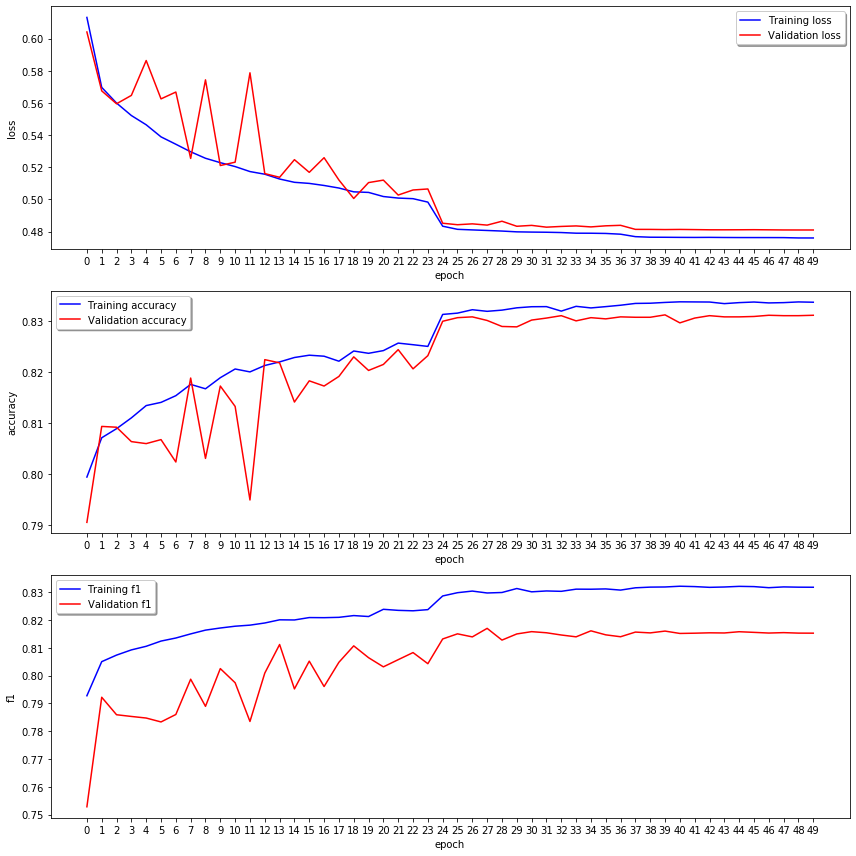

Test loss: 0.481
Test accuracy: 0.831
Test F1: 0.815


In [36]:
loss, accuracy, get_f1  = model.evaluate(X_test, y_test, verbose=False)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Wykres loss
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(numpy.arange(0, len(history.history['val_loss']), 1))
ax1.legend(loc='best', shadow=True)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')

# Wykres accuracy
ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(numpy.arange(0, len(history.history['val_accuracy']), 1))
ax2.legend(loc='best', shadow=True)
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')

# Wykres F1
ax3.plot(history.history['get_f1'], color='b', label="Training f1")
ax3.plot(history.history['val_get_f1'], color='r',label="Validation f1")
ax3.set_xticks(numpy.arange(0, len(history.history['get_f1']), 1))
ax3.legend(loc='best', shadow=True)
ax3.set_ylabel('f1')
ax3.set_xlabel('epoch')


plt.tight_layout()
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')
print(f'Test F1: {get_f1:.3}')


In [37]:
predictions = model.predict(X_test)

In [38]:
# Predykcje są zakodowane w one-hot encoderze, to zamienia wyjście na maxa i zmienia kształt na tabele

predictions = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], predictions)))
predictions = numpy.reshape(predictions, (y_test.shape[0],))

y_pred = predictions

In [39]:
# Etykieta activity jest zakodowana w one-hot encoderze, to zamienia wyjście na maxa i zmienia kształt na tabele
tmp = numpy.array(list(map(lambda x: numpy.where(x == numpy.amax(x))[1], y_test)))
tmp = numpy.reshape(tmp, (y_test.shape[0],))

y_true = tmp

In [40]:
cm = confusion_matrix(y_true, y_pred)

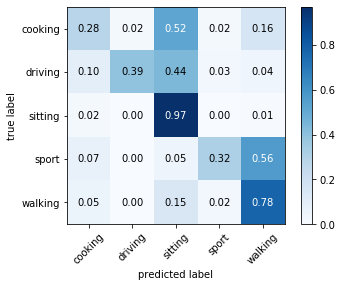

In [41]:
plot_cm(cm, ['cooking', 'driving', 'sitting', 'sport', 'walking'])

In [42]:
print(cm)

[[ 347   24  642   22  199]
 [  25  101  113    7   11]
 [ 153   24 7935   13   55]
 [  28    0   18  119  211]
 [ 140    5  398   67 2106]]


In [43]:
accuracy, precision, recall, fscore = countStats(y_true, y_pred)
print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-score: {fscore}')

Accuracy: 0.8311525503408289
Precision: 0.8090625205503664
Recall: 0.8311525503408289
F-score: 0.8139217211742709


Epoch 1/1
1021/1021 [==============================] - 0s 20us/step
Epoch 1/1
3318/3318 [==============================] - 0s 18us/step
Epoch 1/1
5615/5615 [==============================] - 0s 18us/step
Epoch 1/1
7912/7912 [==============================] - 0s 17us/step
Epoch 1/1
10210/10210 [==============================] - 0s 17us/step
Epoch 1/1
1021/1021 [==============================] - 0s 19us/step
Epoch 1/1
3318/3318 [==============================] - 0s 17us/step
Epoch 1/1
5615/5615 [==============================] - 0s 18us/step
Epoch 1/1
7912/7912 [==============================] - 0s 17us/step
Epoch 1/1
10210/10210 [==============================] - 0s 17us/step
Epoch 1/1
1021/1021 [==============================] - 0s 20us/step
Epoch 1/1
3318/3318 [==============================] - 0s 18us/step
Epoch 1/1
5615/5615 [==============================] - 0s 17us/step
Epoch 1/1
7912/7912 [==============================] - 0s 18us/step
Epoch 1/1
10210/10210 [=====================

<module 'matplotlib.pyplot' from 'C:\\Users\\zelec\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

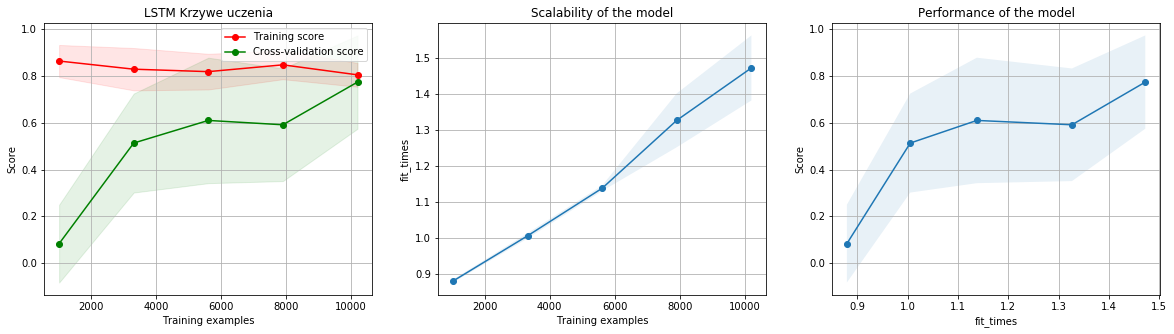

In [44]:
from utils.learning_curve import plot_learning_curve

# Zbudowane na wrapperze + y_test ma zmiejszone wymiary by być zgodne z funkcją i samym modelem
plot_learning_curve(model_wrapper, "LSTM Krzywe uczenia", X_test, numpy.squeeze(y_test, axis=1))